In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from md04_func import *

In [2]:
document=fileRead("543906")
md04=parsingDoc(document)
    

['543906', '2018/04/16', 'Stock', 0, 0, 0, 0]
['543906', '2018/04/16', 'CStock', '5236280263', '000110', 0, 0]
['543906', '2018/04/30', 'ShipNt', '4601952363', '00005', 1, 0]
['543906', '2018/04/16', 'CStock', '5236281646', '000010', 0, 0]
['543906', '2018/07/17', 'ShipNt', '4601956922', '00001', 2, 0]
['543906', '2018/04/16', 'CStock', '5236282681', '000140', 0, 0]
['543906', '2018/07/18', 'ShipNt', '4601960196', '00002', 1, 0]


In [3]:
df=pd.DataFrame(md04['data'], columns=md04['header'])

In [6]:
df['cum']=df.Change.cumsum()

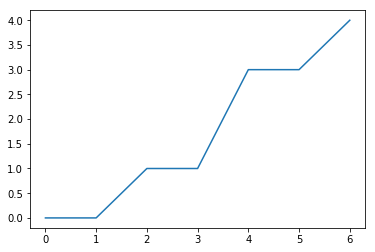

In [14]:
df.cum.plot(x="Date")

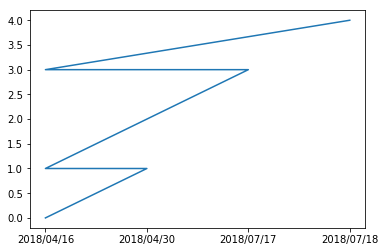

In [17]:
plt.plot(df.Date, df.cum)

In [23]:
target=df.mask('Type','ShipNt')

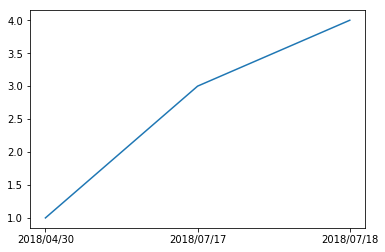

In [24]:
plt.plot(target.Date, target.cum)

In [12]:
df

,Partnr,Date,Type,DocNum,Pos,Change,Avail,cum
0,543906,2018/04/16,Stock,0,0,0,0,0
1,543906,2018/04/16,CStock,5236280263,000110,0,0,0
2,543906,2018/04/30,ShipNt,4601952363,00005,1,0,1
3,543906,2018/04/16,CStock,5236281646,000010,0,0,1
4,543906,2018/07/17,ShipNt,4601956922,00001,2,0,3
5,543906,2018/04/16,CStock,5236282681,000140,0,0,3
6,543906,2018/07/18,ShipNt,4601960196,00002,1,0,4


In [ ]:
df.pivot_table(index="MRPElement", aggfunc=sum)

In [ ]:
df.Rec/reqd qty

In [ ]:
if md04['meta'][-3]=='KMAT' : 
    kmatParser(md04['data'])

In [ ]:
def kmatParser(data) :
    for i in data :
        if 
    



In [ ]:
df.iloc[[2,3,4]]

In [ ]:
df.mask(2,'CStock')

In [ ]:
df = pd.DataFrame(np.random.randint(0, 10, (4,4)), index=list('abcd'), columns=list('ABCD'))
df.ix['d','A'] = df.ix['a', 'A']

In [ ]:
df.mask('A',9).mask('D',2)

In [ ]:
df

In [ ]:
df.

In [ ]:
a=df[df[2]=='CStock'].index

In [ ]:
df[a]

In [ ]:
for idx, value in enumerate(a):
    print (idx)
    df.loc[i][2]
    print(df.loc[i+1])

In [ ]:
for idx, val in enumerate(ints):
    print(idx, val)

In [ ]:
for idx,val in enumerate(md04['data']):
    print (idx,val)
    if (val[3]=='CStock')
     

In [ ]:
for i in md04['data'] :
    print

In [ ]:
df[:][3:4]

In [ ]:
a

In [ ]:
df

In [ ]:
for line in document[22:-3] :
    print(line.split("|")[4].strip().split("/"))
    

In [ ]:
for i in md04['data']:
    print (i)

In [ ]:
filelist=[]
f=open("MD04list.txt","r", encoding="UTF-8")
list=f.readlines()
for i in list :        
    document=fileRead(i.rstrip("\n"))
    md04=parsingDoc(document)
    PD=pd.DataFrame(md04["data"], columns=md04["header"]) 
    
    
fig = plt.figure()
ax= PD['Rec/reqd Qty'].plot(x="Date", kind="bar", title=md04['meta'][0])
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),PD['AvailQty'])

In [ ]:
md04

In [ ]:
md04=parsingDoc(fileRead("543946"))
PD=pd.DataFrame(md04["data"], columns=md04["header"])   
PD

In [ ]:
PD.plot(x="Date", kind="bar", title=md04['meta'][0])

In [ ]:
PD

In [ ]:
-int(float(md04['data'][0][-1].strip()))

In [ ]:
PD[['Date', 'Rec/reqd Qty']]

In [ ]:
float('10.000')

In [ ]:
int(float(0))

In [ ]:
d